In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import ttest_ind, chi2, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
data = pd.read_excel("df_total.xlsx")

In [3]:
# 去掉8和999
# 轉成字串並去除空白
data['Part_nbr'] = data['Part_nbr'].astype(str).str.strip()

# 建立條件
mask = data['Part_nbr'].str.startswith('8') | data['Part_nbr'].str.startswith('999')

# 過濾資料
data = data.loc[~mask].copy()


In [4]:
data.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'CamX', 'CamY', 'AVGX',
       'AVGY', 'Credate', 'MacNo', 'MacRecipe', 'mtl_desc1', 'mtl_desc2',
       'mtl_desc4', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual Copper Rate', 'glass_fabric_thickness(mm)',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'parse_failed_desc', 'bake', 'bake_after_browning',
       'short', 'long', 'd_PSVarX', 'd_PSVarY', 'bake_result', 'bake_measured',
       'bake_after_browning_result', 'bake_after_browning_measured'],
      dtype='object')

<p style = "font_size: 16; color: blue;">欄位選擇</p>

In [5]:
data = data[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer','MacNo', 'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr',
         'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_value',
         'Residual Copper Rate', 'glass_fabric_thickness(mm)','use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
         'glass_fabric_type', 'short', 'long','bake_result', 'bake_measured','bake_after_browning_result', 'bake_after_browning_measured',
         'd_PSVarX', 'd_PSVarY']]

data = data.copy()
data['layer_2Thick'] = data['layer_2Thick'].replace('None', np.nan).astype(float)
data['layer_2Thick'] = data['layer_2Thick'].astype('float')

data['plate_mtl_desc2'] = data['plate_mtl_desc2'].astype('float')

data['bake_result'] =data['bake_result'].astype('O')
data['bake_measured'] =data['bake_measured'].astype('O')
data['bake_after_browning_result'] =data['bake_after_browning_result'].astype('O')
data['bake_after_browning_measured'] =data['bake_after_browning_measured'].astype('O')

data['plate_layer_2Thick'] = pd.to_numeric(data['plate_layer_2Thick'], errors='coerce')
data = data.rename(columns={"glass_fabric_thickness(mm)": "glass_fabric_thickness_mm"})
data = data.rename(columns={"Residual Copper Rate": "Residual_Copper_Rate"})

data["glass_fabric_type"] = data["glass_fabric_type"].astype(str).str.replace(r"\+$", "", regex=True)

<p style = "font_size: 16; color: red;">Full Data</p>

<p style = "font_size: 16; color: blue;">合併少數料號</p>

In [6]:
df = data

# 找出小於閾值的料號列表
part_counts = df['Part_nbr'].value_counts()

threshold = 30
below_threshold_parts = part_counts[part_counts < threshold].index.tolist()

print(f"小於 {threshold} 筆數據的料號共有 {len(below_threshold_parts)} 個：")
# print(below_threshold_parts)

小於 30 筆數據的料號共有 835 個：


In [7]:
# 計算各料號的觀測數
part_counts = df['Part_nbr'].value_counts()

threshold = 30
df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < threshold,   'OTHER', df['Part_nbr'])

# 按分位數合併（合併底部25%）
# quantile_threshold = part_counts.quantile(0.25)
# df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < quantile_threshold, 'OTHER', df['Part_nbr'])

<p style = "font_size: 16; color: blue;">Modeling 前處理</p>

<p style = "font_size: 14; color: green;">RC 處理</p>

In [8]:
def categorize_plate_rc(value):
    if pd.isna(value):
        return "Missing"
    elif value >= 70:
        return "High"
    elif value <= 60:
        return "Low"
    else:
        return "Median"

df["plate_RC_cat"] = df["plate_RC_value"].apply(categorize_plate_rc)

In [9]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

MacRecipe: 154 missing value
mtl_desc4: 782 missing value
use_cu_type: 1411 missing value


MacRecipe      0
mtl_desc4      0
use_cu_type    0
dtype: int64

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [10]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df[feature].isnull().sum(), 'missing values')

layer_2Thick 4330 missing values
plate_layer_2Thick 24024 missing values
plate_RC_value 5811 missing values
glass_fabric_thickness_mm 782 missing values
use_cu_upper_thickness 782 missing values
use_cu_lower_thickness 782 missing values
short 3365 missing values
long 3365 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [11]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

Number of features:  14


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [12]:
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 3


['MacNo', 'use_cu_upper_thickness', 'use_cu_lower_thickness']

In [13]:
df['use_cu_lower_thickness'] = df['use_cu_lower_thickness'].astype('O')
df['use_cu_upper_thickness'] = df['use_cu_upper_thickness'].astype('O')

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [14]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

19
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'mtl_desc4', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type', 'glass_fabric_type', 'bake_result', 'bake_measured', 'bake_after_browning_result', 'bake_after_browning_measured', 'Part_nbr_grouped', 'plate_RC_cat']


In [15]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))

The feature is Part_nbr and number of categories are 1235
The feature is Lot_nbr and number of categories are 4206
The feature is Layer and number of categories are 17
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 182
The feature is mtl_desc4 and number of categories are 62
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 96
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_upper_thickness and number of categories are 6
The feature is use_cu_lower_thickness and number of categories are 6
The feature is use_cu_type and number of categories are 32
The feature is glass_fabric_type and number of categories are 64
The feature is bake_result and number of categories are 2
The feature is bake_measured and number of categories are 2
The feature is bake_after_browning_result and number of categories are 2
The feature is bake_after_bro

<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [16]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

use_cu_upper_thickness: 782 missing value
use_cu_lower_thickness: 782 missing value


In [17]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

use_cu_upper_thickness    0
use_cu_lower_thickness    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [18]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

layer_2Thick: 4330 missing value
plate_layer_2Thick: 24024 missing value
plate_RC_value: 5811 missing value
glass_fabric_thickness_mm: 782 missing value
short: 3365 missing value
long: 3365 missing value


In [19]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df[feature] = df.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                        .transform(lambda x: x.fillna(x.median()))

# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df[feature] = df[feature].fillna(df[feature].median())


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [20]:
df[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
plate_RC_value               0
glass_fabric_thickness_mm    0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [21]:
categorical_feattures = [feature for feature in df.columns if df[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'mtl_desc4',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_upper_thickness',
 'use_cu_lower_thickness',
 'use_cu_type',
 'glass_fabric_type',
 'bake_result',
 'bake_measured',
 'bake_after_browning_result',
 'bake_after_browning_measured',
 'Part_nbr_grouped',
 'plate_RC_cat']

In [22]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# 把字串 'nan' 轉成真正的 NaN
df[processed_categorical_features] = (
    df[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)
)

features_cat_nan = [
    feature for feature in processed_categorical_features
    if df[feature].isnull().sum() > 1 and df[feature].dtype == 'O'
]

df = replace_cat_feature(df, features_cat_nan)

# rare category 合併
for feature in processed_categorical_features:
    temp = df.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df[feature] = np.where(df[feature].isin(temp_df), df[feature], 'rare cate')

C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_11320\4141101046.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)


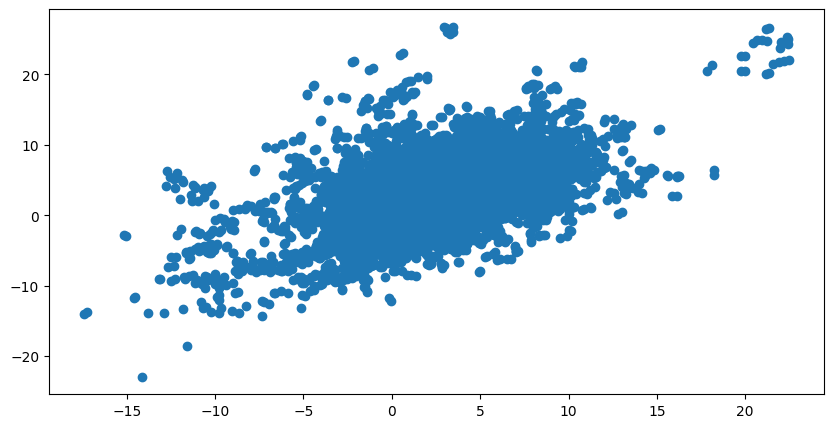

In [23]:
df = df[df['d_PSVarX'] < 4000]
df = df[df['d_PSVarY'] < 4000]
plt.figure(figsize=(10,5))
plt.scatter(df['d_PSVarX'],df['d_PSVarY'])

<p style="font-size: 14px; color: green;">拆分出異常資料<p>

In [24]:
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups

df_unfiltered = df

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df_unfiltered), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

原始資料筆數: 55017 正常批資料筆數: 30069
總批數: 4205 正常批數: 2523


<p style = "font_size: 16; color: red;">Filter Data</p>

<p style="font-size: 14px; color: green;">以批號判定正常 / 異常<p>

In [25]:
df_unfiltered = data

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

# 列出不正常的 batch（供檢查）
abnormal_batches = batch_stats[~batch_stats['is_normal']].sort_values(['range','mean'], ascending=[False, True])
abnormal_batches.head(30).to_csv('abnormal_batches_top30.csv', index=False)
# print("已輸出 abnormal_batches_top30.csv (供檢查)")

原始資料筆數: 55017 正常批資料筆數: 30069
總批數: 4206 正常批數: 2523


In [26]:
# 正常批 少量的料號合併
part_counts = df_filtered['Part_nbr'].value_counts()

threshold = 30
df_filtered['Part_nbr_grouped'] = np.where(df_filtered['Part_nbr'].map(part_counts) < threshold,   'OTHER', df_filtered['Part_nbr'])

<p style = "font_size: 14; color: green;">RC 處理</p>

In [27]:
def categorize_plate_rc(value):
    if pd.isna(value):
        return "Missing"
    elif value >= 70:
        return "High"
    elif value <= 60:
        return "Low"
    else:
        return "Median"

df_filtered["plate_RC_cat"] = df_filtered["plate_RC_value"].apply(categorize_plate_rc)

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [28]:
features_with_na = [features for features in df_filtered.columns if df_filtered[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df_filtered[feature].isnull().sum(), 'missing values')

MacRecipe 80 missing values
mtl_desc4 304 missing values
layer_2Thick 2626 missing values
plate_layer_2Thick 13238 missing values
plate_RC_value 2001 missing values
glass_fabric_thickness_mm 304 missing values
use_cu_upper_thickness 304 missing values
use_cu_lower_thickness 304 missing values
use_cu_type 624 missing values
short 1612 missing values
long 1612 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [29]:
numerical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  15


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [30]:
discrete_feature = [feature for feature in numerical_features if len(df_filtered[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 4


['MacNo',
 'use_cu_upper_thickness',
 'use_cu_lower_thickness',
 'batch_is_normal']

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [31]:
categorical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

18
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'mtl_desc4', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type', 'bake_result', 'bake_measured', 'bake_after_browning_result', 'bake_after_browning_measured', 'Part_nbr_grouped', 'plate_RC_cat', '_batch_key']


In [32]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df_filtered[feature].unique())))

The feature is Part_nbr and number of categories are 995
The feature is Lot_nbr and number of categories are 2523
The feature is Layer and number of categories are 16
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 150
The feature is mtl_desc4 and number of categories are 58
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 90
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_type and number of categories are 30
The feature is glass_fabric_type and number of categories are 59
The feature is bake_result and number of categories are 2
The feature is bake_measured and number of categories are 2
The feature is bake_after_browning_result and number of categories are 2
The feature is bake_after_browning_measured and number of categories are 2
The feature is Part_nbr_grouped and number of categories are 203
The feature is plate_RC_cat 

<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [33]:
features_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

MacRecipe: 80 missing value
mtl_desc4: 304 missing value
use_cu_type: 624 missing value


In [34]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df_filtered = replace_cat_feature(df_filtered, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df_filtered[features_nan].isnull().sum()

MacRecipe      0
mtl_desc4      0
use_cu_type    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [35]:
numerical_with_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

layer_2Thick: 2626 missing value
plate_layer_2Thick: 13238 missing value
plate_RC_value: 2001 missing value
glass_fabric_thickness_mm: 304 missing value
use_cu_upper_thickness: 304 missing value
use_cu_lower_thickness: 304 missing value
short: 1612 missing value
long: 1612 missing value


In [36]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df_filtered[feature + '_nan'] = np.where(df_filtered[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df_filtered[feature] = df_filtered.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                             .transform(lambda x: x.fillna(x.median()))


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [37]:
print('numbers of NaN in the all lot with df_filtered: \n')
for feature in numerical_with_nan:
    print('{}: {}'.format(feature, df_filtered[feature].isnull().sum()))

numbers of NaN in the all lot with df_filtered: 

layer_2Thick: 2626
plate_layer_2Thick: 2626
plate_RC_value: 16
glass_fabric_thickness_mm: 0
use_cu_upper_thickness: 0
use_cu_lower_thickness: 0
short: 1454
long: 1454


In [38]:
# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df_filtered[feature] = df_filtered[feature].fillna(df_filtered[feature].median())


In [39]:
df_filtered[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
plate_RC_value               0
glass_fabric_thickness_mm    0
use_cu_upper_thickness       0
use_cu_lower_thickness       0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [40]:
categorical_feattures = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'mtl_desc4',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_type',
 'glass_fabric_type',
 'bake_result',
 'bake_measured',
 'bake_after_browning_result',
 'bake_after_browning_measured',
 'Part_nbr_grouped',
 'plate_RC_cat',
 '_batch_key']

In [41]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# 把字串 'nan' 轉成真正的 NaN
df_filtered[processed_categorical_features] = (
    df_filtered[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)
)

features_cat_nan = [
    feature for feature in processed_categorical_features
    if df[feature].isnull().sum() > 1 and df_filtered[feature].dtype == 'O'
]

df_filtered = replace_cat_feature(df_filtered, features_cat_nan)

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df_filtered)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')


C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_11320\912970358.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered[processed_categorical_features].replace(['nan', 'NaN', 'NULL'], np.nan)


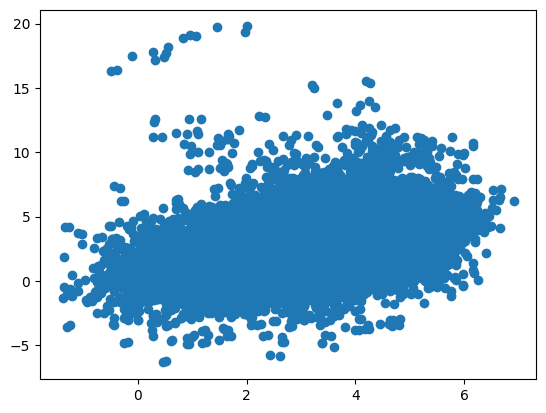

In [42]:
plt.scatter(df_filtered['d_PSVarX'],df_filtered['d_PSVarY'])

In [43]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')


<p style="font-size: 16px; color: blue;">Modeling<p>

<p style="font-size: 14px; color: green;">檢查欄位<p>

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ---- 1. 定義要標準化的特徵 ----

#################################### MinMax for the Part_nbr_grouped ####################
# 確保特徵存在
feature_scale = [
    'mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
    'glass_fabric_thickness_mm', 'short', 'long'
]

feature_scale = [feature for feature in feature_scale if feature in df.columns]

df_scaled = df.copy()
df_filtered_scaled = df_filtered.copy()

# ---- 以料號群組做 MinMax ----
for feat in feature_scale:
    df_scaled[feat] = df_scaled.groupby("Part_nbr_grouped")[feat].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    df_filtered_scaled[feat] = df_filtered_scaled.groupby("Part_nbr_grouped")[feat].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )
#########################################################################################
# # ---- 3. 對 target d_PSVarX 做 Shift + log1p ----
# target = 'd_PSVarX'

# # 找最小值
# shift = -df_scaled[target].min() + 1 if df_scaled[target].min() <= 0 else 0

# df_scaled[target + '_log'] = np.log1p(df_scaled[target] + shift)
# df_filtered_scaled[target + '_log'] = np.log1p(df_filtered_scaled[target] + shift)

# print(f"Shift value used for log transform: {shift}")

df_filtered = df_filtered_scaled
# df_filtered['d_PSVarX'] = df_filtered_scaled['d_PSVarX_log']
df = df_scaled
# df['d_PSVarX'] = df['d_PSVarX_log']

In [45]:
# df_filtered['plate_mtl_desc2'].unique()

In [46]:
import statsmodels.formula.api as smf
import patsy as pt

features = ['MacNo', 'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'Residual_Copper_Rate',
             'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_cat',
              'glass_fabric_thickness_mm','use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
             'glass_fabric_type', 'short', 'bake_result', 'bake_after_browning_result', 'd_PSVarX'] 
formula = "d_PSVarX ~ " + " + ".join(features[:-1])  # 最後一個 features 其實是 d_PSVarX 本身，所以要去掉

target, X = pt.dmatrices(formula,  df_filtered[features], return_type="dataframe")
rank = np.linalg.matrix_rank(X.values)
cond = np.linalg.cond(X.values)
print("X shape:", X.shape, " rank:", rank, "  cond:", cond)

X shape: (30069, 80)  rank: 80   cond: 1150.5456217969024


<p style="font-size: 14px; color: green;">分離規律與隨機<p>

In [47]:
# 分離Residual_Copper_Rate or glass_fabric_thickness_mm

df_filtered = df_filtered.copy()
grp_mean = df_filtered.groupby('Part_nbr_grouped')['glass_fabric_thickness_mm'].transform('mean')
df_filtered['GFT_within']  = df_filtered['glass_fabric_thickness_mm'] - grp_mean
df_filtered['GFT_between'] = grp_mean

df_filtered = df_filtered.copy()
grp_mean = df_filtered.groupby('Part_nbr_grouped')['plate_layer_2Thick'].transform('mean')
df_filtered['plate_layer_2Thick_within']  = df_filtered['plate_layer_2Thick'] - grp_mean
df_filtered['plate_layer_2Thick_between'] = grp_mean

df_filtered = df_filtered.copy()
grp_mean = df_filtered.groupby('Part_nbr_grouped')['short'].transform('mean')
df_filtered['short_within']  = df_filtered['short'] - grp_mean
df_filtered['short_between'] = grp_mean


# within_var = df_filtered.groupby('Part_nbr_grouped')[['mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
#                 'glass_fabric_thickness_mm',  'short', 'long', 'RCR_within', 'RCR_between']].var()
# within_var#.iloc[:30,:]
# df_filtered

<p style="font-size: 14px; color: green;">料號vs批號<p>

In [48]:
# lot_counts_per_part = df_filtered.groupby('Part_nbr_grouped')['Lot_nbr'].nunique()

# lot_counts_df = lot_counts_per_part.reset_index()
# lot_counts_df.columns = ['Part_nbr', 'Lot_count']

# # print(lot_counts_df['Lot_count'].describe())
# lot_counts_df.sort_values(by='Lot_count',ascending=False)

In [49]:
df = df.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups  plate_RC_value    C(plate_RC_cat)
formula = """
d_PSVarX ~ mtl_desc2 +  plate_layer_2Thick + Residual_Copper_Rate + glass_fabric_thickness_mm +  short  +
           C(use_cu_type) + C(glass_fabric_type) + C(plate_RC_cat) + C(vend_nbr)
           """

# formula = """
# d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
#            Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
#            C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo) + 
#            C(bake_result) + C(bake_after_browning_result)
#            """
vc = {"Part_nbr_grouped": "0 + C(Part_nbr_grouped)",
      # "MacNo": "0 + C(MacNo)",
      # "MacRecipe": "0 + C(MacRecipe)
      # "Vend": "0 + C(vend_nbr)"
}
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")


In [103]:
df_filtered = df_filtered.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups  --C(vend_nbr) + C(MacRecipe) + C(MacNo) +
formula2 = """
d_PSVarX ~  plate_layer_2Thick_between +  GFT_between + Residual_Copper_Rate + C(mtl_desc4) + C(use_cu_upper_thickness) +
           C(use_cu_type) + C(glass_fabric_type) + C(plate_RC_cat) +  C(vend_nbr)  + C(MacRecipe) 
           + C(plate_vend_nbr)
           """
vc = {
      "Part_nbr_grouped": "0 + C(Part_nbr_grouped)",
      "MacNo": "0 + C(MacNo)"
      # "MacRecipe": "0 + C(MacRecipe)"
  # "Vend": "0 + C(vend_nbr)"
}

formula2 = """
d_PSVarX ~  plate_layer_2Thick_between +  GFT_between + Residual_Copper_Rate + C(mtl_desc4) + 
           C(use_cu_type) + C(glass_fabric_type) + C(plate_RC_cat) +  C(vend_nbr, Treatment(reference='聯茂')) + C(use_cu_upper_thickness) + C(MacRecipe)
           + C(plate_vend_nbr, Treatment(reference='台光')) + C(MacNo)
           """

# vc2 = {
#       "Part_nbr_grouped": "0 + C(Part_nbr_grouped)",
#       # "MacNo": "0 + C(MacNo)"
#       # "MacRecipe": "0 + C(MacRecipe)"
#   # "Vend": "0 + C(vend_nbr)"
# }
# -------------------------------------

# 檢查必要欄位存在
# for c in group_cols + [target, group_for_mixed]:
#     if c not in df.columns:
#         raise ValueError(f"資料裡缺少欄位：{c}")


<p style="font-size: 14px; color: green;">定義 fit + diagnostics 函式<p>

In [104]:
# md_reml = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed],vc_formula=vc, 
#                       re_formula="1 + GFT_within + plate_layer_2Thick_within")
# res_reml = md_reml.fit(reml=True, method='bfgs', maxiter=2000)

md_reml2 = smf.mixedlm(formula2, df_filtered, groups=df_filtered[group_for_mixed],vc_formula=vc,
                       re_formula="1 + GFT_within + plate_layer_2Thick_within")
res_reml2 = md_reml2.fit(reml=True, method='bfgs', maxiter=2000)

In [64]:
res_reml.vcomp, res_reml2.vcomp

(array([0.54999156, 0.23859824]), array([0.52835976, 0.12339895]))

In [65]:
from scipy.stats import chi2

df_diff = res_reml2.df_modelwc - res_reml.df_modelwc # 模型的總參數數量(規律+隨機)
# df_diff = res_ml2.k_fe - res_ml.k_fe               # 或 len(res2.fe_params) - len(res1.fe_params)

# likelihood ratio
lr_stat = 2 * (res_reml2.llf - res_reml.llf)
p_value = chi2.sf(lr_stat, df=df_diff)

print("Likelihood Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.4g}")

Likelihood Ratio Test Results:
LR Statistic: 458.4551
Degrees of Freedom: 46
p-value: 2.325e-69


In [59]:
res_reml.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                       MixedLM           Dependent Variable:           d_PSVarX   
No. Observations:            30069             Method:                       REML       
No. Groups:                  203               Scale:                        1.0477     
Min. group size:             30                Log-Likelihood:               -44414.8695
Max. group size:             9947              Converged:                    No         
Mean group size:             148.1                                                      
----------------------------------------------------------------------------------------
                                           Coef.   Std.Err.     z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                   3.324      0.103  32.313 0.000  3.123  3.526
C(use_cu_type)[T.HVLP]                     -0.650      0.050 -12.877 0.000 -0.748 -0.551
C(use_cu_type)[T.HVLP2]                    -0.332      0.073  -4.529 0.000 -0.476 -0.188
C(use_cu_type)[T.Missing]                  -0.518      0.071  -7.276 0.000 -0.658 -0.379
C(use_cu_type)[T.RG311]                    -0.530      0.049 -10.888 0.000 -0.626 -0.435
C(use_cu_type)[T.RG312]                    -0.419      0.049  -8.467 0.000 -0.516 -0.322
C(use_cu_type)[T.RTF]                      -0.372      0.037  -9.955 0.000 -0.445 -0.299
C(use_cu_type)[T.VLP]                      -0.498      0.048 -10.282 0.000 -0.593 -0.403
C(use_cu_type)[T.rare cate]                -0.416      0.045  -9.194 0.000 -0.504 -0.327
C(glass_fabric_type)[T.1067*2]              0.576      0.066   8.778 0.000  0.447  0.704
C(glass_fabric_type)[T.1078*1]              0.305      0.048   6.345 0.000  0.211  0.400
C(glass_fabric_type)[T.1080*1]              0.102      0.083   1.226 0.220 -0.061  0.265
C(glass_fabric_type)[T.1080*2]              0.559      0.073   7.685 0.000  0.416  0.702
C(glass_fabric_type)[T.1086*1]              0.287      0.057   5.012 0.000  0.175  0.400
C(glass_fabric_type)[T.2113*1]              0.655      0.104   6.319 0.000  0.452  0.858
C(glass_fabric_type)[T.2116*1]              0.164      0.055   2.988 0.003  0.056  0.271
C(glass_fabric_type)[T.3313*1]              0.321      0.056   5.748 0.000  0.212  0.431
C(glass_fabric_type)[T.rare cate]           0.226      0.053   4.308 0.000  0.123  0.330
C(plate_RC_cat)[T.Low]                     -0.014      0.024  -0.579 0.562 -0.060  0.032
C(plate_RC_cat)[T.Median]                  -0.058      0.020  -2.945 0.003 -0.096 -0.019
C(plate_RC_cat)[T.Missing]                 -0.238      0.051  -4.703 0.000 -0.338 -0.139
C(vend_nbr)[T.南亞]                          -0.243      0.058  -4.176 0.000 -0.357 -0.129
C(vend_nbr)[T.台光]                           0.229      0.061   3.761 0.000  0.110  0.349
C(vend_nbr)[T.台燿]                           0.000      0.055   0.004 0.997 -0.107  0.108
C(vend_nbr)[T.聯茂]                           0.256      0.067   3.832 0.000  0.125  0.387
mtl_desc2                                  -0.048      0.034  -1.390 0.165 -0.115  0.020
plate_layer_2Thick                          0.059      0.032   1.847 0.065 -0.004  0.122
Residual_Copper_Rate                        0.095      0.019   5.105 0.000  0.058  0.131
glass_fabric_thickness_mm                   0.070      0.063   1.114 0.265 -0.053  0.194
short                                      -0.047      0.027  -1.733 0.083 -0.101  0.006
Group Var                                   0.239 915295.627                            
Group x GFT_within Cov                      0.014      0.062                            
GFT_within Var                              0.283      0.055                            
Group x plate_layer_2Thick_within Cov      -0.003      0.020 

In [87]:
df_filtered['MacNo'].unique()

array([ 2,  1,  4, 22,  3, 23, 21, 24, 25, 29, 27, 31, 26, 11, 30])

In [105]:
res_reml2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
====================================================================================================
Model:                           MixedLM               Dependent Variable:               d_PSVarX   
No. Observations:                30069                 Method:                           REML       
No. Groups:                      203                   Scale:                            1.0315     
Min. group size:                 30                    Log-Likelihood:                   -44185.6420
Max. group size:                 9947                  Converged:                        Yes        
Mean group size:                 148.1                                                              
----------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Intercept                                                  4.010    0.520  7.715 0.000  2.991  5.029
C(mtl_desc4)[T.EM-890]                                     0.347    0.141  2.461 0.014  0.071  0.624
C(mtl_desc4)[T.EM-890K]                                   -0.118    0.141 -0.837 0.403 -0.396  0.159
C(mtl_desc4)[T.IT-170GRA1TC]                               0.567    0.151  3.755 0.000  0.271  0.863
C(mtl_desc4)[T.NP-175FMTL]                                 0.054    0.149  0.361 0.718 -0.239  0.346
C(mtl_desc4)[T.NPG-170D]                                   0.362    0.151  2.403 0.016  0.067  0.657
C(mtl_desc4)[T.NPG-171]                                    0.405    0.150  2.703 0.007  0.111  0.699
C(mtl_desc4)[T.NPG-188H]                                   0.687    0.162  4.247 0.000  0.370  1.005
C(mtl_desc4)[T.TU-883]                                     0.426    0.137  3.103 0.002  0.157  0.696
C(mtl_desc4)[T.TU-883C]                                    0.234    0.130  1.792 0.073 -0.022  0.489
C(mtl_desc4)[T.TU-933+]                                    0.413    0.140  2.945 0.003  0.138  0.688
C(mtl_desc4)[T.TU862HF]                                    0.653    0.135  4.828 0.000  0.388  0.918
C(mtl_desc4)[T.rare cate]                                  0.249    0.122  2.046 0.041  0.010  0.487
C(use_cu_type)[T.HVLP]                                    -0.431    0.057 -7.558 0.000 -0.543 -0.319
C(use_cu_type)[T.HVLP2]                                    0.152    0.097  1.568 0.117 -0.038  0.342
C(use_cu_type)[T.Missing]                                 -0.354    0.085 -4.158 0.000 -0.521 -0.187
C(use_cu_type)[T.RG311]                                   -0.258    0.057 -4.530 0.000 -0.370 -0.146
C(use_cu_type)[T.RG312]                                   -0.148    0.056 -2.614 0.009 -0.258 -0.037
C(use_cu_type)[T.RTF]                                     -0.214    0.049 -4.368 0.000 -0.310 -0.118
C(use_cu_type)[T.VLP]                                     -0.298    0.052 -5.689 0.000 -0.401 -0.196
C(use_cu_type)[T.rare cate]                               -0.209    0.050 -4.219 0.000 -0.306 -0.112
C(glass_fabric_type)[T.1067*2]                             0.354    0.071  4.957 0.000  0.214  0.494
C(glass_fabric_type)[T.1078*1]                             0.206    0.054  3.842 0.000  0.101  0.310
C(glass_fabric_type)[T.1080*1]                            -0.159    0.088 -1.802 0.071 -0.332  0.014
C(glass_fabric_type)[T.1080*2]                             0.443    0.077  5.744 0.000  0.292  0.594
C(glass_fabric_type)[T.1086*1]                             0.142    0.062  2.288 0.022  0.020  0.263
C(glass_fabric_type)[T.2113*1]                             0.478    0.103  4.665 0.000  0.277  0.679
C(glass_fabric_type)[T.2116*1]                             0.108    0.059  1.832 0.067 -0.008  0.223
C(glass_fabric_type)[T.3313*1]              

In [81]:
# len(df_filtered[df_filtered['vend_nbr']=='聯茂']),len(df_filtered[df_filtered['vend_nbr']=='台光']),len(df_filtered[df_filtered['vend_nbr']=='台燿']),len(df_filtered[df_filtered['vend_nbr']=='南亞'])

(1150, 6076, 13484, 8565)

In [52]:
res_reml2.cov_re

,Group,GFT_within,plate_layer_2Thick_within
Group,0.169235,0.107549,0.020598
GFT_within,0.107549,0.240042,0.002090
plate_layer_2Thick_within,0.020598,0.002090,0.037056


In [67]:
# 每個料號的隨機效應
re_dict = res_reml2.random_effects

# 查看前 5 個料號
for part, effects in list(re_dict.items())[:5]:
    print(part, effects)

import pandas as pd

re_df = pd.DataFrame.from_dict(re_dict, orient='index')
re_df.reset_index(inplace=True)
re_df.rename(columns={'index': 'Part_nbr'}, inplace=True)
re_df.head()


107S004C78C Group                                                 0.164578
GFT_within                                            0.068365
plate_layer_2Thick_within                             0.133806
MacNo[C(MacNo)[1]]                                    0.301124
MacNo[C(MacNo)[2]]                                    0.000921
Part_nbr_grouped[C(Part_nbr_grouped)[107S004C78C]]    0.070543
dtype: float64
107S009A78C Group                                                 0.169528
GFT_within                                            0.542513
plate_layer_2Thick_within                            -0.038920
MacNo[C(MacNo)[1]]                                   -0.023920
MacNo[C(MacNo)[4]]                                    0.153726
MacNo[C(MacNo)[22]]                                  -0.370421
Part_nbr_grouped[C(Part_nbr_grouped)[107S009A78C]]   -0.056196
dtype: float64
107S013B08C Group                                                 0.293497
GFT_within                                          

,Part_nbr,Group,GFT_within,plate_layer_2Thick_within,MacNo[C(MacNo)[1]],MacNo[C(MacNo)[2]],Part_nbr_grouped[C(Part_nbr_grouped)[107S004C78C]],MacNo[C(MacNo)[4]],MacNo[C(MacNo)[22]],Part_nbr_grouped[C(Part_nbr_grouped)[107S009A78C]],...,Part_nbr_grouped[C(Part_nbr_grouped)[708S016AF3G]],Part_nbr_grouped[C(Part_nbr_grouped)[713S014AC8Q]],Part_nbr_grouped[C(Part_nbr_grouped)[722S003BC3B]],Part_nbr_grouped[C(Part_nbr_grouped)[730S016EC3B]],Part_nbr_grouped[C(Part_nbr_grouped)[730S087C0IN]],Part_nbr_grouped[C(Part_nbr_grouped)[750Q009B5LG]],Part_nbr_grouped[C(Part_nbr_grouped)[770Q029I93C]],Part_nbr_grouped[C(Part_nbr_grouped)[770Q029J93C]],Part_nbr_grouped[C(Part_nbr_grouped)[770Q030A88C]],Part_nbr_grouped[C(Part_nbr_grouped)[OTHER]]
0,107S004C78C,0.164578,0.068365,0.133806,0.301124,0.000921,0.070543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,107S009A78C,0.169528,0.542513,-0.038920,-0.023920,NaN,NaN,0.153726,-0.370421,-0.056196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,107S013B08C,0.293497,0.034645,0.108278,NaN,NaN,NaN,0.691819,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,110EB91C58C,0.405547,0.258424,0.047164,0.268370,0.572609,NaN,0.429242,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110EC06A68C,-0.562537,-0.312229,-0.210630,-1.109060,-0.382593,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# re_df.to_excel('re_df.xlsx')

In [76]:
md_ml = smf.mixedlm(formula2, df_filtered, groups=df_filtered[group_for_mixed], vc_formula=vc, re_formula="1 + GFT_within + plate_layer_2Thick_within")
res_ml = md_reml.fit(reml=False, method='bfgs', maxiter=2000)
res_ml.aic, res_ml.bic

C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 64.181818
  warnings.warn(msg, ConvergenceWarning)


(np.float64(88759.88546290505), np.float64(89084.02421367307))

<p style="font-size: 14px; color: green;">boostrap<p>

In [56]:
import statsmodels.formula.api as smf

group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~  plate_layer_2Thick_between +  GFT_between + Residual_Copper_Rate + C(mtl_desc4) + 
           C(use_cu_type) + C(glass_fabric_type) + C(plate_RC_cat) +  C(vend_nbr) + C(use_cu_upper_thickness) + C(MacRecipe)
           + C(plate_vend_nbr) + C(MacNo)
           """
# vc = {
#       "Part_nbr_grouped": "0 + C(Part_nbr_grouped)",
#       "MacNo": "0 + C(MacNo)"
# }


n_boot = 300
coef_results = []

for i in range(n_boot):
    # bootstrap by group
    boot_df = df_filtered.groupby(group_for_mixed, group_keys=False)\
                         .apply(lambda x: x.sample(frac=1, replace=True))
    try:
        # boot_model = smf.mixedlm(formula, boot_df, groups=boot_df[group_for_mixed])
        boot_model = smf.mixedlm(formula, boot_df, groups=boot_df[group_for_mixed],  re_formula="1 + GFT_within + plate_layer_2Thick_within")
        boot_result = boot_model.fit(reml=True, method='bfgs', maxiter=2000)
        coef_results.append(boot_result.params)
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

# 匯總結果
coef_df = pd.DataFrame(coef_results)

summary_df = pd.DataFrame({
    "mean": coef_df.mean(),
    "std": coef_df.std(),
    "2.5%": coef_df.quantile(0.025),
    "97.5%": coef_df.quantile(0.975)
})

print(summary_df)



C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_17628\804663724.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=1, replace=True))
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_17628\804663724.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=1, replace=True))
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_17628\804663724.py:21: FutureWarning:

<p style="font-size: 14px; color: green;">畫殘差診斷圖 (QQ + Fitted vs Residuals)<p>

Diagnostics: Reduced model
Diagnostics: Full model


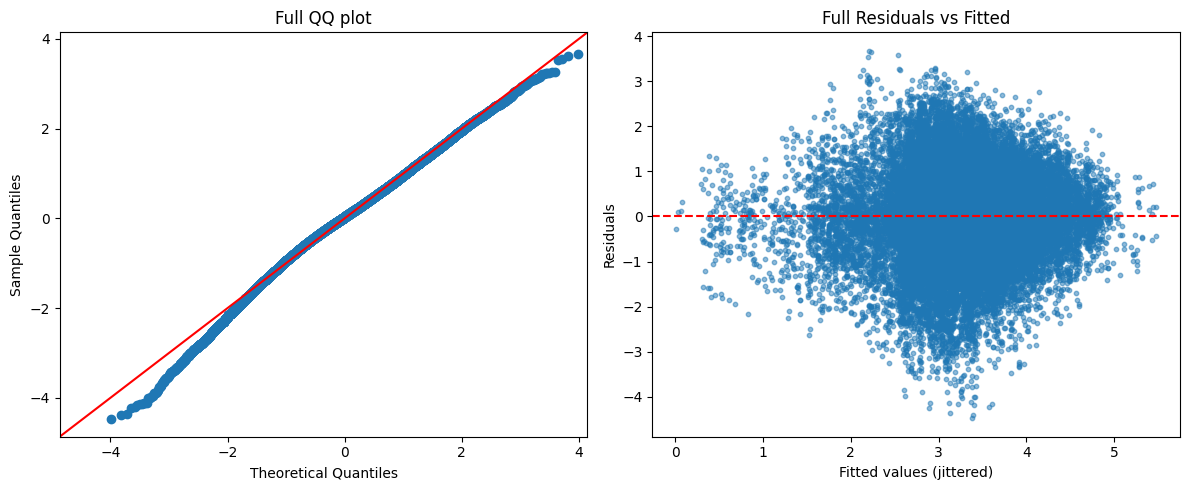

In [72]:
def plot_diagnostics(res_obj, fitted, resid, title_prefix):
    # 創建一個新的圖形，設置大小
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    # 第一個子圖：QQ圖
    sm.qqplot(resid, line='45', fit=True, ax=ax1)
    ax1.set_title(f'{title_prefix} QQ plot')

    # 第二個子圖：殘差圖
    ax2.scatter(fitted + np.random.normal(0, 1e-6, size=len(fitted)), resid, alpha=0.5, s=10)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Fitted values (jittered)')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{title_prefix} Residuals vs Fitted')
    
    plt.tight_layout()
    plt.show()

print("Diagnostics: Reduced model")
# plot_diagnostics(res_reml, res_reml.fittedvalues, res_reml.resid, 'Reduced')

print("Diagnostics: Full model")
plot_diagnostics(res_reml2, res_reml2.fittedvalues, res_reml2.resid, 'Full')

In [73]:
durbin_watson(res_reml2.resid) # 獨立ok

np.float64(0.5616807432387976)

In [74]:
kurtosis(res_reml2.resid)

np.float64(0.4971537370445116)

In [58]:
y = df_filtered["d_PSVarX"].values
y_mean = np.mean(y)

# fitted (含隨機效應)
y_hat_cond = res_reml2.fittedvalues
# fitted (只固定效應)
fe_params = res_reml2.fe_params
X_fe = res_reml2.model.exog
y_hat_marg = X_fe @ fe_params

# 總變異
var_y = np.var(y, ddof=1)

# Marginal R²
R2_marg = 1 - np.var(y - y_hat_marg, ddof=1) / var_y
# Conditional R²
R2_cond = 1 - np.var(y - y_hat_cond, ddof=1) / var_y

print("Marginal R²:", R2_marg)
print("Conditional R²:", R2_cond)

Marginal R²: 0.03418791512363717
Conditional R²: 0.3263129354426242


<p style="font-size: 14px; color: green;">ICC（群內相關係數） —> 直觀看 group variance 比例<p>

In [67]:
def compute_icc(res, verbose=False):
    """
    從 statsmodels MixedLMResults 物件取出 group variance (cov_re) 與 residual variance (scale),
    並計算 ICC = group_var / (group_var + resid_var).
    支援 cov_re 為 DataFrame / ndarray / Series，及 >1 隨機效果的情形 (使用 trace).
    """
    # 1) 取得 cov_re，轉成 ndarray
    cov_re = getattr(res, 'cov_re', None)
    if cov_re is None:
        raise ValueError("res 物件沒有 cov_re 屬性。請確認 res 是 mixedlm 的 fit 結果。")

    # 將可能的 pandas 結構轉為 numpy array
    if isinstance(cov_re, pd.DataFrame) or isinstance(cov_re, pd.Series):
        cov_arr = cov_re.values
    else:
        cov_arr = np.asarray(cov_re)

    # 2) 決定 group variance 的計算方式
    # 若是 1x1，直接取 scalar；否則取 trace（總變異）
    if cov_arr.size == 1:
        group_var = float(cov_arr.ravel()[0])
    else:
        # 若 cov_arr 非方陣，嘗試取方陣部分；一般 cov_re 應為方陣
        if cov_arr.shape[0] != cov_arr.shape[1]:
            if verbose:
                print("警告：cov_re 不是方陣，shape =", cov_arr.shape)
            # 退而求其次：取對角和
            group_var = float(np.diag(cov_arr).sum())
        else:
            group_var = float(np.trace(cov_arr))

    # 3) 取得 residual variance
    resid_var = float(getattr(res, 'scale', np.nan))

    # 4) 數值穩定處理：如果出現負值(理論上不應該)，將其夾到 0
    if np.isnan(group_var) or np.isinf(group_var):
        raise ValueError("group_var 為 NaN 或 infinite，請檢查 fit 結果。")
    if group_var < 0:
        if verbose:
            print(f"注意：group_var = {group_var} < 0，將其設為 0.")
        group_var = 0.0
    if resid_var < 0:
        if verbose:
            print(f"注意：resid_var = {resid_var} < 0，將其設為 0.")
        resid_var = 0.0

    # 5) 計算 ICC（若分母為 0 則回傳 NaN）
    denom = group_var + resid_var
    icc = group_var / denom if denom > 0 else np.nan

    if verbose:
        print("cov_re type:", type(cov_re), "cov_re shape:", getattr(cov_re, 'shape', cov_arr.shape))
        print("group_var:", group_var, "resid_var:", resid_var, "ICC:", icc)

    return group_var, resid_var, icc


gvar_full, rvar_full, icc_full = compute_icc(res_reml2, verbose=True)
print("FULL  -> group_var: {:.4f}, resid_var: {:.4f}, ICC: {:.3f}".format(gvar_full, rvar_full, icc_full))


# ICC 就是「隨機效果總變異 / (總變異 + 殘差變異)」

# ICC 越高代表 Part_nbr 之間的差異相對於總變異越大（群間影響大）；ICC 低則群內變異占比高。

# 比較 full vs filtered 的 ICC，可以看出你過濾掉的資料佔了多少 between/within variation（你之前的數字顯示過濾後 both 減小）。


cov_re type: <class 'pandas.core.frame.DataFrame'> cov_re shape: (3, 3)
group_var: 0.4463330108306765 resid_var: 1.0314655109792836 ICC: 0.30202561732435773
FULL  -> group_var: 0.4463, resid_var: 1.0315, ICC: 0.302


<p style="font-size: 14px; color: green;">best model<p>